# Trajectory inference with Raman artificial dataset    

Dynverse provides an user friendly and unified package with about 60 methods of different trajectory inference (TI) methods. Dynverse uses docker containers, making it easy to try various TI methods without installing all packages. Furthermore, dynverse provides metrics to compare TI methods. However, it may be necessary to use native packages to deal with the full range of options.For more information on the dynverse package please refer to https://dynverse.org/reference/dynwrap/ and for PAGA https://scanpy.readthedocs.io/en/stable/tutorials.html

In [7]:
library(dyno)
library(tidyverse)
library(Matrix)
library(reshape)
library(reticulate)
library(viridis)
library("RColorBrewer")
library(svglite)
Paired <- brewer.pal(n =12, name = 'Paired')
Set3 <- brewer.pal(n =12, name = 'Set3')
color <- c(Paired,Set3)


In [8]:
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 19042)

Matrix products: default

locale:
[1] LC_COLLATE=French_France.1252  LC_CTYPE=French_France.1252   
[3] LC_MONETARY=French_France.1252 LC_NUMERIC=C                  
[5] LC_TIME=French_France.1252    

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] reticulate_1.22       svglite_2.0.0         RColorBrewer_1.1-2   
 [4] viridis_0.6.2         viridisLite_0.4.0     reshape_0.8.8        
 [7] Matrix_1.3-4          forcats_0.5.1         stringr_1.4.0        
[10] dplyr_1.0.7           purrr_0.3.4           readr_2.1.0          
[13] tidyr_1.1.4           tibble_3.1.6          ggplot2_3.3.5        
[16] tidyverse_1.3.1       dyno_0.1.2            dynwrap_1.2.2        
[19] dynplot_1.1.1         dynmethods_1.0.5.9000 dynguidelines_1.0.1  
[22] dynfeature_1.0.0     

loaded via a namespace (and not a

# Data import 

In [9]:
# Open the pandas python package (reticulate package)
pd <- import("pandas")

# Open pickle file with pandas 
Spectra_dataframe <- pd$read_pickle("C:/Users/cosmic/Desktop/Jupyterbooks/Toy_Dataset_25_05_2021_12h.pkl")

# Some formatting...
Spectra = Matrix(as.matrix(Spectra_dataframe),sparse=TRUE)

# Create a wrapper object with Raman Spectra

We replace the scRNA-seq's expression and counting matrix by our Raman spectra 

In [10]:
dataset <- wrap_expression(
  counts = Spectra,
  expression = Spectra,
  dimred_acp = dyndimred::dimred_pca(Spectra))

# Trajectory inference

dynwrap::infer_trajectory is the main function to infer a trajectory methods. 
The list of TI methods is available on the page: https://dynverse.org/reference/dynmethods/

In [11]:
model_paga <- infer_trajectory(
  dataset = dataset,
  method = dynmethods::ti_projected_paga(filter_features = FALSE, 
                                         resolution = 0.5L,
                                         embedding_type = "umap"),verbose = FALSE)

# Plotting functions

Umap embedding 

Coloring by grouping

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



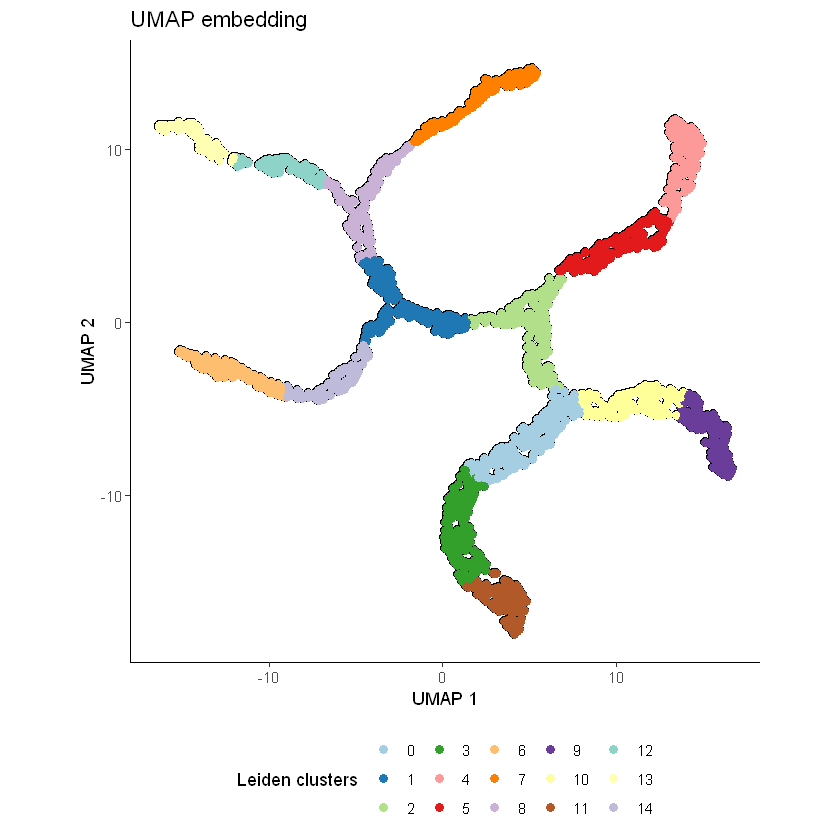

In [12]:
plot_dimred(model_paga, grouping = group_onto_nearest_milestones(model_paga),label_milestones=FALSE, plot_trajectory=FALSE)+
theme_classic()+
theme(legend.position = "bottom")+
labs(title = "UMAP embedding",
     x = "UMAP 1",
     y = "UMAP 2")+
scale_color_manual(values=color,name = "Leiden clusters",
                  breaks = c("0","1","2","3","4","5","6","7","8","9","10","11","12","13","14"))

Switch to scanpy package to visualize PAGA representation (Dynverse package don't have this function). The scanpy package is originally available via python, however the R package "reticulate" allows to use python packages on the R kernel. 

In [ ]:
# We recover the cluster informations. 
group <- data.frame(model_paga$grouping)
colnames(group) <- 'leiden'
group$leiden <- as.factor(group$leiden)

# Python package import. 
sc <- import("scanpy")
ad <- import("anndata")
np <- import("numpy")
plt <- import("matplotlib")

# Adata File.
adata <- sc$AnnData(Spectra_dataframe, obs = group)

# compute PAGA graph via scanpy.
sc$pp$neighbors(adata, n_neighbors= as.integer(25), metric ='euclidean')
sc$tl$paga(adata)

# Select a cut-off value on PAGA connectivities. 
sc$pl$paga(adata, threshold = 0.0)
sc$pl$paga(adata, threshold = 0.1)
sc$pl$paga(adata, threshold = 0.2)

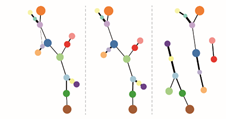

Centroids plotting 

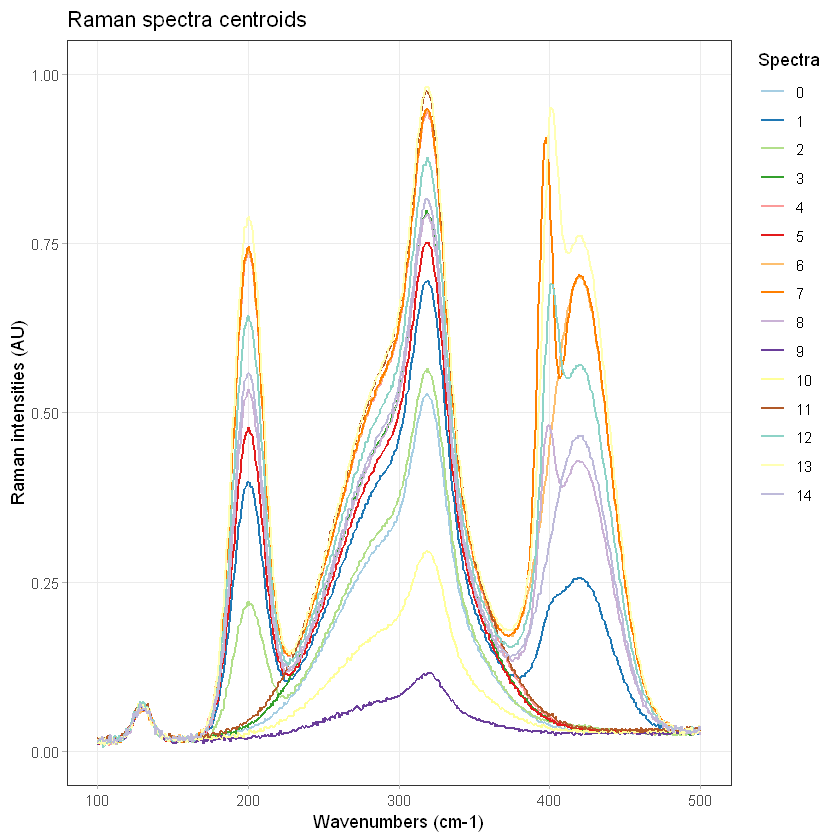

In [13]:
WL_cm <- colnames(Spectra_dataframe)
WL = as.numeric(substr(colnames(Spectra_dataframe),1,nchar(colnames(Spectra_dataframe))-5))

group_id <- data.frame(as.numeric(model_paga$grouping))
colnames(group_id)<-c('Leiden')
colnames(Spectra_dataframe) <- WL
dat <- data_frame(group_id, Spectra_dataframe)
cluster <- aggregate(dat, by=dat[1], FUN=mean)
cluster <- cluster[-2]
cluster2 <- melt(cluster ,  id.vars = 'Leiden')
cluster2$variable <- as.numeric(as.character(cluster2$variable))
cluster2$Leiden <- factor(as.character(cluster2$Leiden), levels = as.character(0:(length(model_paga$group_id)-1)))


c <- ggplot(cluster2, aes(x = variable, y = value))+
    geom_line(aes(color = Leiden), size = 0.8, linetype = "solid") +
    theme_bw()+
    theme(legend.position = "right",
    legend.background = element_rect(fill = "white", size = 4, colour = "white"),
    legend.justification = c(0, 1),
   
    axis.ticks = element_line(colour = "grey70", size = 0.2),

    panel.grid.minor = element_blank()) +
    xlab("Wavenumbers (cm-1)")+
    ylim(0, 1)+
    ylab("Raman intensities (AU)")+
    labs(title = "Raman spectra centroids")+
    scale_color_manual(values=c(color[0:15]),name = "Spectra",
                      breaks = c("0","1","2","3","4","5","6","7","8","9","10","11","12","13","14"))
c
#ggsave(file="centroides.svg", plot=c, width=width, height=height, bg = "transparent")
#ggsave(file="centroides.tiff", plot=c, width=width, height=height, bg = "transparent")

# Select a ROOT

In [14]:
model_paga_rooted <- model_paga %>% add_root(root_milestone_id = "9")
model_paga_rooted <- add_pseudotime(model_paga_rooted)
model_paga_rooted <- add_expression(model_paga_rooted, expression = dataset$expression, counts = dataset$expression)

# Pseudotime plotting 

<ScaleContinuous>
 Range:  
 Limits:    0 --    1

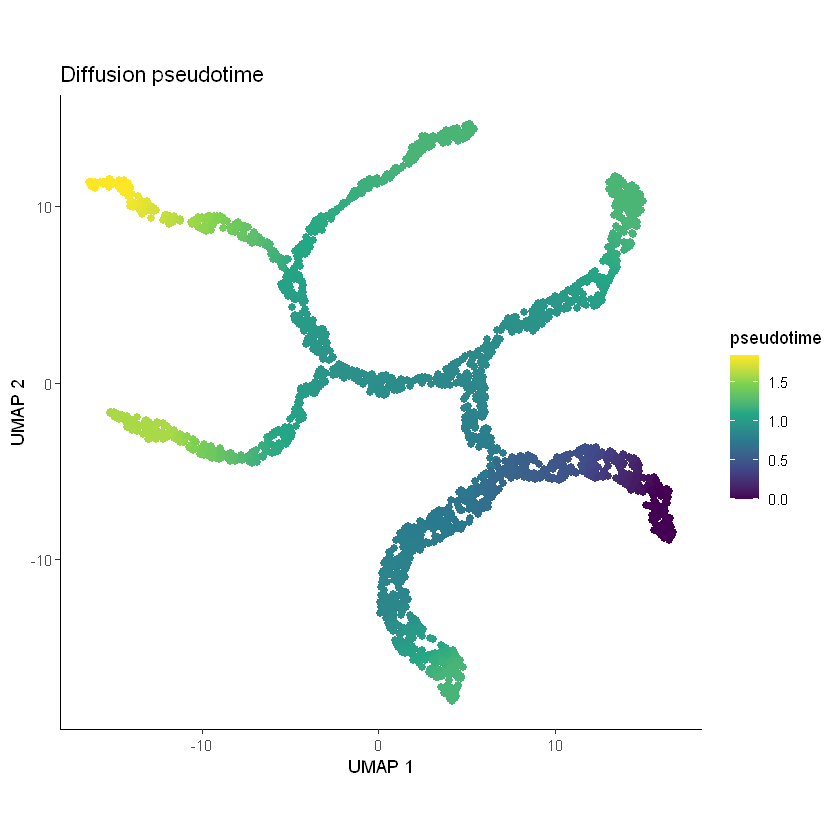

In [15]:
######### 3) PSEUDOTEMPS

pseudo <- plot_dimred(
  model_paga_rooted, 
  expression_source = dataset$expression, 
  color_cells = "pseudotime",
  plot_trajectory = FALSE,
  size_cells = 2)+
theme_classic()+
theme(legend.position = "right")+
labs(title = "Diffusion pseudotime",
       x = "UMAP 1",
       y = "UMAP 2")
scale_colour_gradientn(colours = viridis(100) ,name = "Pseudotime   ")
pseudo
#ggsave(file="pseudotime_UMAP.svg", plot=pseudo, width=width, height=height, bg = "transparent")
#ggsave(file="pseudotime_UMAP.tiff", plot=pseudo, width=width, height=height, bg = "transparent")

Coloring by expression

Coloring by expression



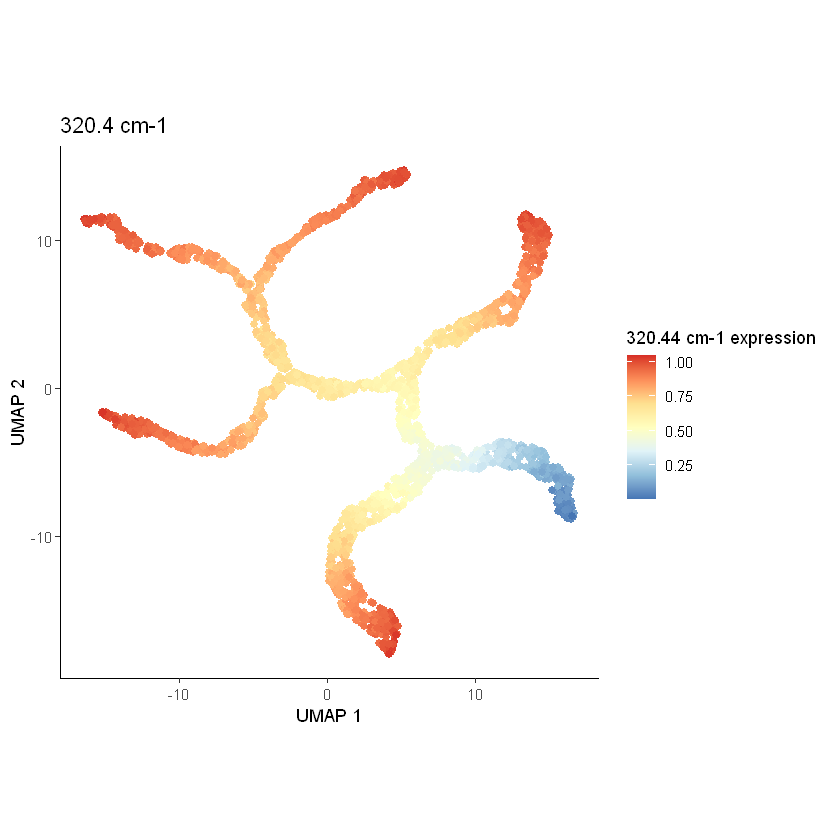

Coloring by expression



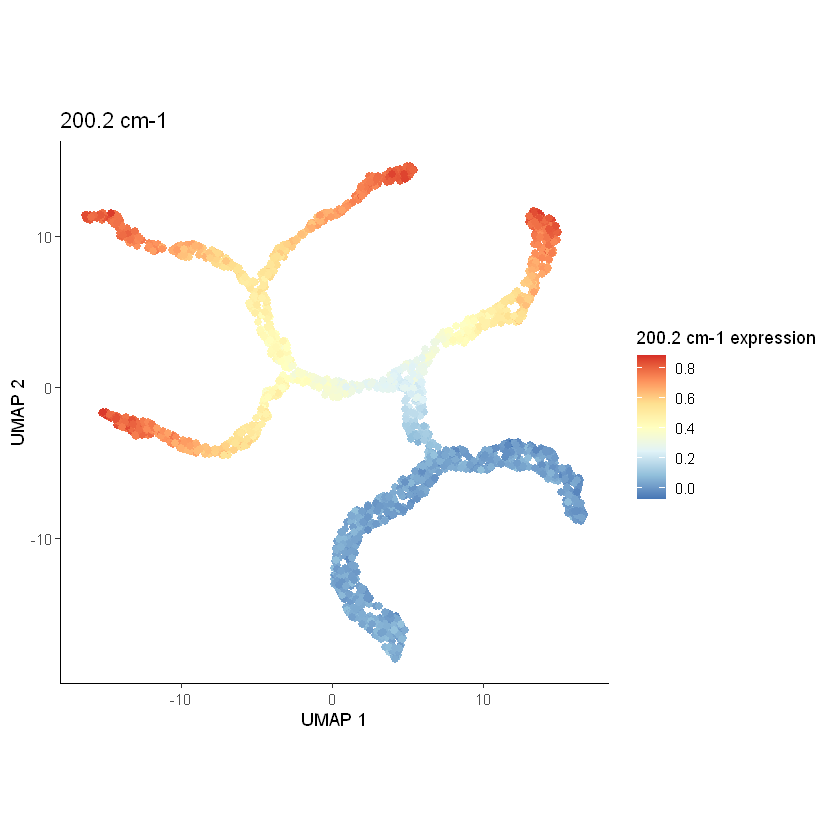

Coloring by expression



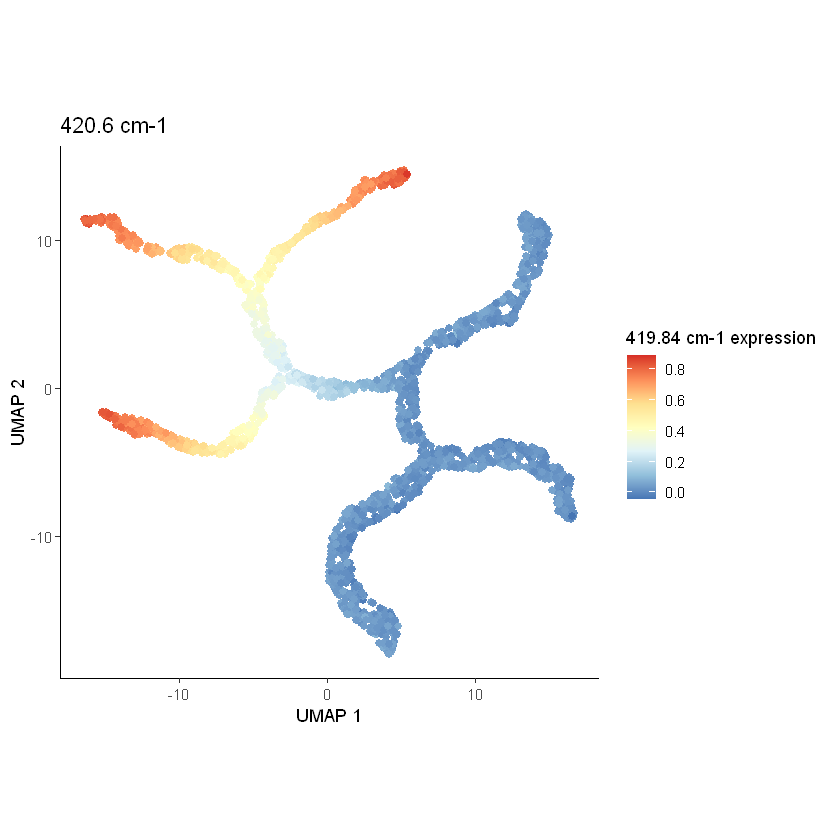

Coloring by expression



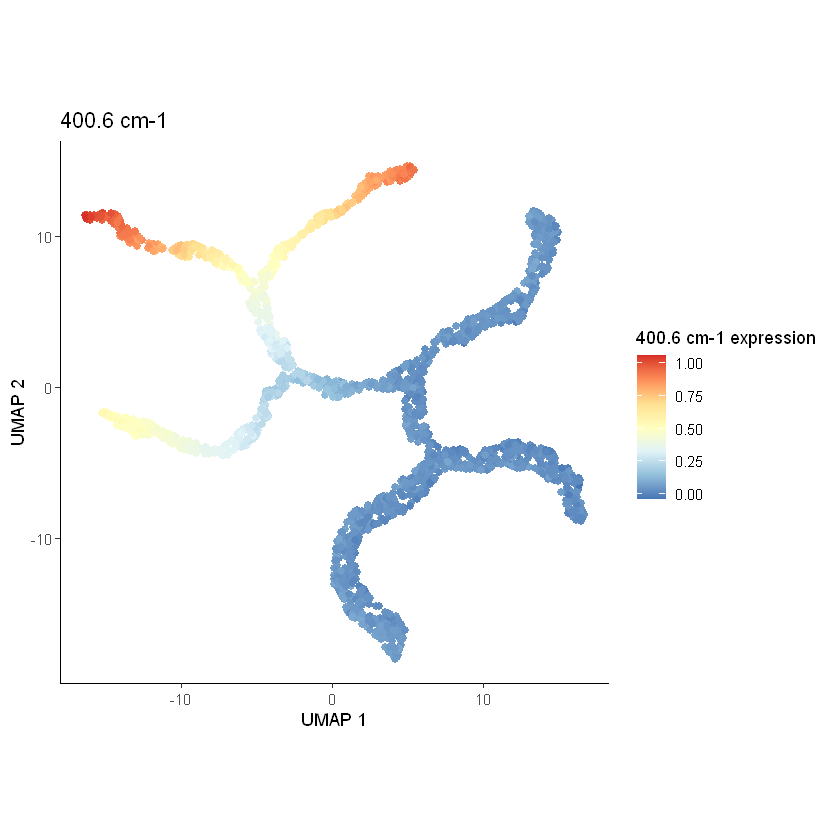

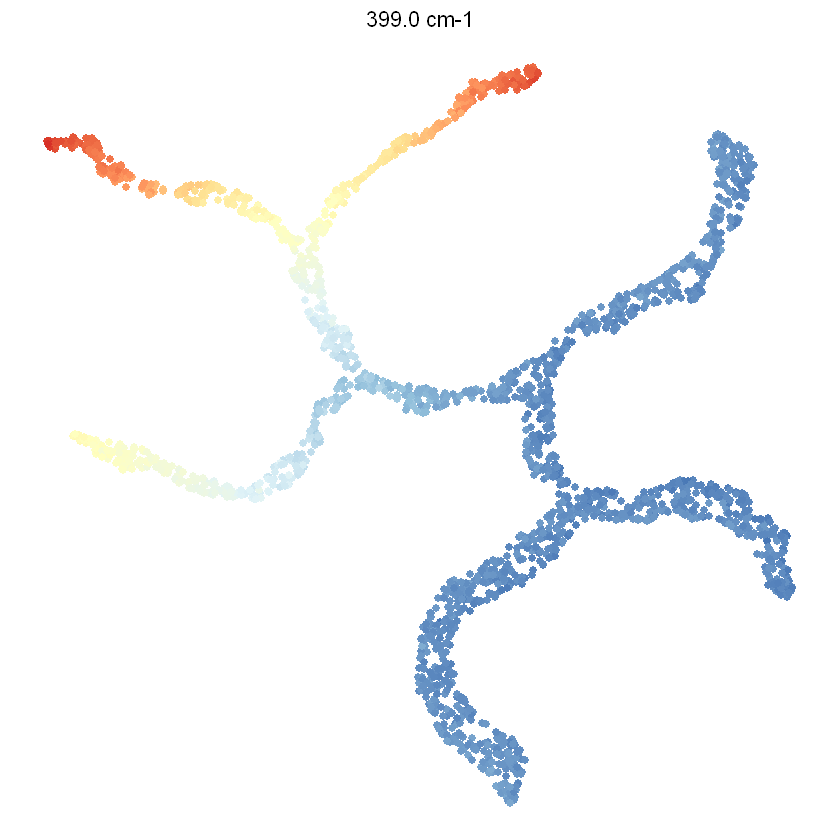

In [16]:
plot_dimred(model_paga_rooted, feature_oi = c("320.44 cm-1"),size_cells = 2,label_milestones=FALSE, plot_trajectory = FALSE, expression_source = dataset)+ ggtitle("320.4 cm-1")+ theme(legend.position = "none")+theme_classic()+labs(
      title = "320.4 cm-1",
       x = "UMAP 1",
       y = "UMAP 2")
plot_dimred(model_paga_rooted, feature_oi = c("200.2 cm-1"),size_cells = 2, label_milestones=FALSE, plot_trajectory = FALSE,expression_source = dataset)+ ggtitle("200.2 cm-1")+ theme(legend.position = "none")+theme_classic()+labs(
      title = "200.2 cm-1",
       x = "UMAP 1",
       y = "UMAP 2")
plot_dimred(model_paga_rooted, feature_oi = c("419.84 cm-1"),size_cells = 2, label_milestones=FALSE, plot_trajectory = FALSE,expression_source = dataset)+ ggtitle("420.6 cm-1")+ theme(legend.position = "none")+theme_classic()+labs(
      title = "420.6 cm-1",
       x = "UMAP 1",
       y = "UMAP 2")
plot_dimred(model_paga_rooted, feature_oi = c("400.6 cm-1"),size_cells = 2, label_milestones=FALSE, plot_trajectory = FALSE,expression_source = dataset)+ ggtitle("400.6 cm-1")+ theme(legend.position = "none")+theme_classic()+labs(
      title = "400.6 cm-1",
       x = "UMAP 1",
       y = "UMAP 2")
plot_dimred(model_paga_rooted, feature_oi = c("399.8 cm-1"),size_cells = 2, label_milestones=FALSE, plot_trajectory = FALSE,expression_source = dataset)+ ggtitle("399.0 cm-1")+ theme(legend.position = "none")+labs(
      title = "399.0 cm-1",
       x = "UMAP 1",
       y = "UMAP 2")


# Simplyfing

Intermediate milestones can be removed by simplyfing the trajectory

In [17]:
# On simplifie les trajectoires
simplified <- simplify_trajectory(model_paga_rooted, allow_self_loops = FALSE)
miles_network<- simplified$milestone_network
miles_network

from,to,length,directed
<chr>,<chr>,<dbl>,<lgl>
0,2,0.13722766,TRUE
2,1,0.08973182,TRUE
1,8,0.15283241,TRUE
8,7,0.12810952,TRUE
0,11,0.50661670,TRUE
2,4,0.37663549,TRUE
9,0,0.71317681,TRUE
8,13,0.75395883,TRUE
1,6,0.65738143,TRUE


# plotting the directed graph

Coloring by grouping

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



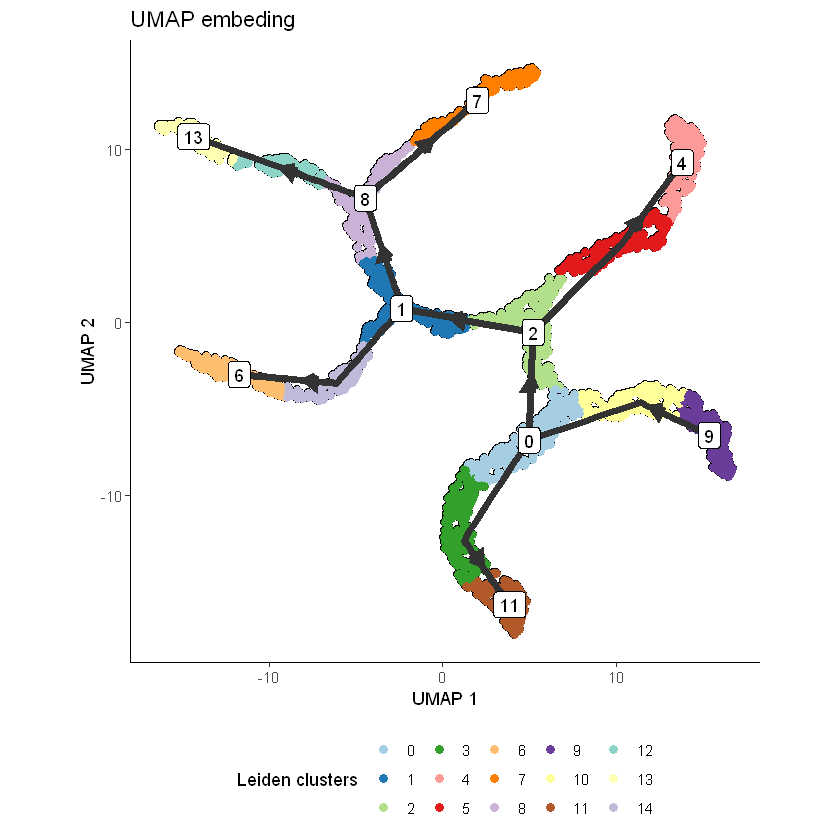

In [18]:
plot_dimred(simplified, grouping = group_onto_nearest_milestones(model_paga),
                , label_milestones=TRUE)+
theme_classic()+
theme(legend.position = "bottom")+
labs(title = "UMAP embeding",
       x = "UMAP 1",
       y = "UMAP 2")+
scale_color_manual(values=color,name = "Leiden clusters",
                  breaks = c("0","1","2","3","4","5","6","7","8","9","10","11","12","13","14"))

rename some specific clusters

In [19]:
simplified <- simplified %>% label_milestones(c( "0" = "M1",
                                                 "1" = "M3",
                                                 "2" = "M2",
                                                 "4" = "End 2",                                    
                                                 "6" = "End 3",
                                                 "7" = "End 4",
                                                 "8" = "M4",
                                                 "9"= "Start",                                                
                                                 "11"="End 1",
                                                 "13"= "End 5"
                                                                      
                                                           ))

simplified$milestone_network 

from,to,length,directed
<chr>,<chr>,<dbl>,<lgl>
0,2,0.13722766,TRUE
2,1,0.08973182,TRUE
1,8,0.15283241,TRUE
8,7,0.12810952,TRUE
0,11,0.50661670,TRUE
2,4,0.37663549,TRUE
9,0,0.71317681,TRUE
8,13,0.75395883,TRUE
1,6,0.65738143,TRUE


Plotting the directed graph

Coloring by grouping

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



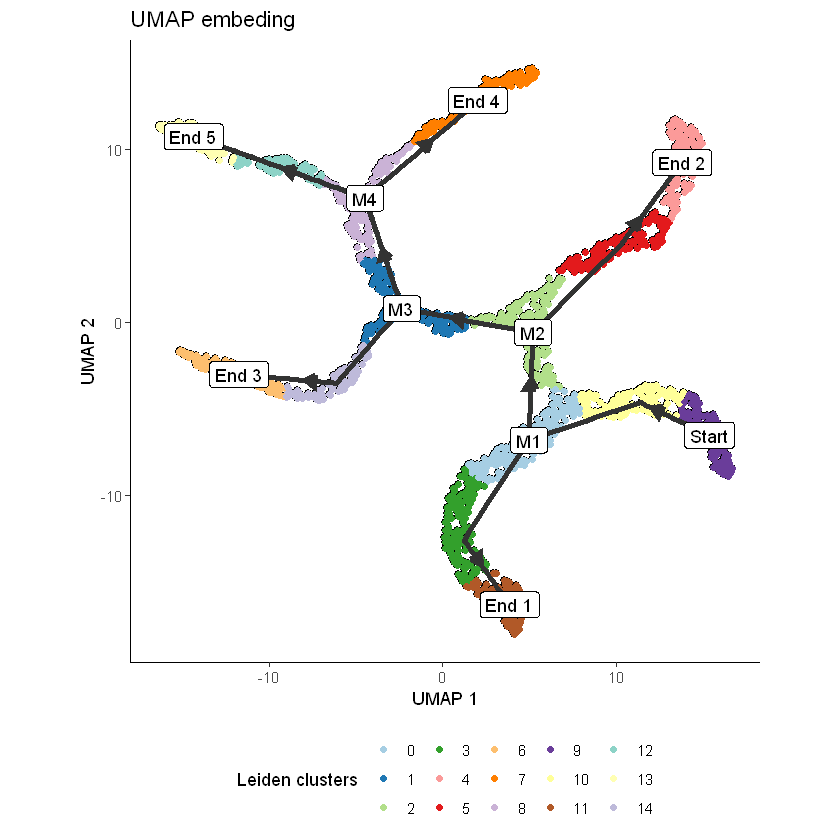

In [20]:
a <-plot_dimred(simplified, grouping = group_onto_nearest_milestones(model_paga_rooted), 
                 border_radius_percentage = .2,
                 arrow = grid::arrow(type = "closed", length = unit(0.1, "inches")),
                 size_cells = 2, label_milestones=TRUE,size_milestones = 5,  size_transitions = 1.5 )+

theme_classic()+
theme(legend.position = "bottom")+
labs(title = "UMAP embeding",
       x = "UMAP 1",
       y = "UMAP 2")+
scale_color_manual(values=color,name = "Leiden clusters", breaks = c(as.character(0:(length(model_paga$group_id)-1))))

#ggsave(file="simplified.svg", plot=a, width=7, height=7, bg = "transparent")
#ggsave(file="simplified.tiff", plot=a, width=7, height=7, bg = "transparent")
a

# HEATMAP 

specifying a specific order to plot heatmap

In [21]:
modified_milestone_networks <- bind_rows(miles_network[7,],
                                          miles_network[5,],
                                          miles_network[1,],
                                          miles_network[6,],
                                          miles_network[2,],
                                          miles_network[9,],
                                          miles_network[3,],
                                          miles_network[8,],
                                          miles_network[4,]
                                     )

simplified$milestone_network <- modified_milestone_networks

Coloring by milestone



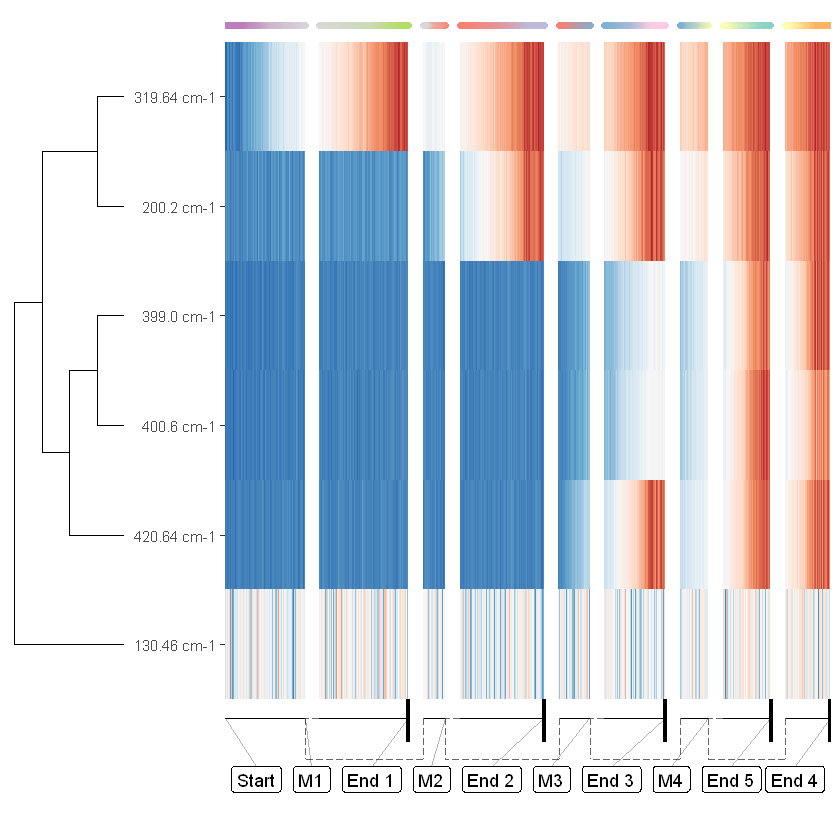

In [33]:
selected_features = c('130.46 cm-1', '200.2 cm-1','319.64 cm-1', '400.6 cm-1', '399.0 cm-1', '420.64 cm-1')

heatmap <- plot_heatmap(simplified,
             expression_source = dataset$expression,                      
             features_oi = selected_features,
             clust = "ward.D2",    
             margin = 0.03,
            
             scale = dynutils::scale_minmax
             )+
theme(text = element_text(size = 5))       

#ggsave(file="heatmap_6.tiff", plot=heatmap, width=12, height=12, bg = "transparent")
#ggsave(file="heatmap_6.svg", plot=heatmap, width=12, height=12, bg = "transparent")
heatmap

Coloring by milestone



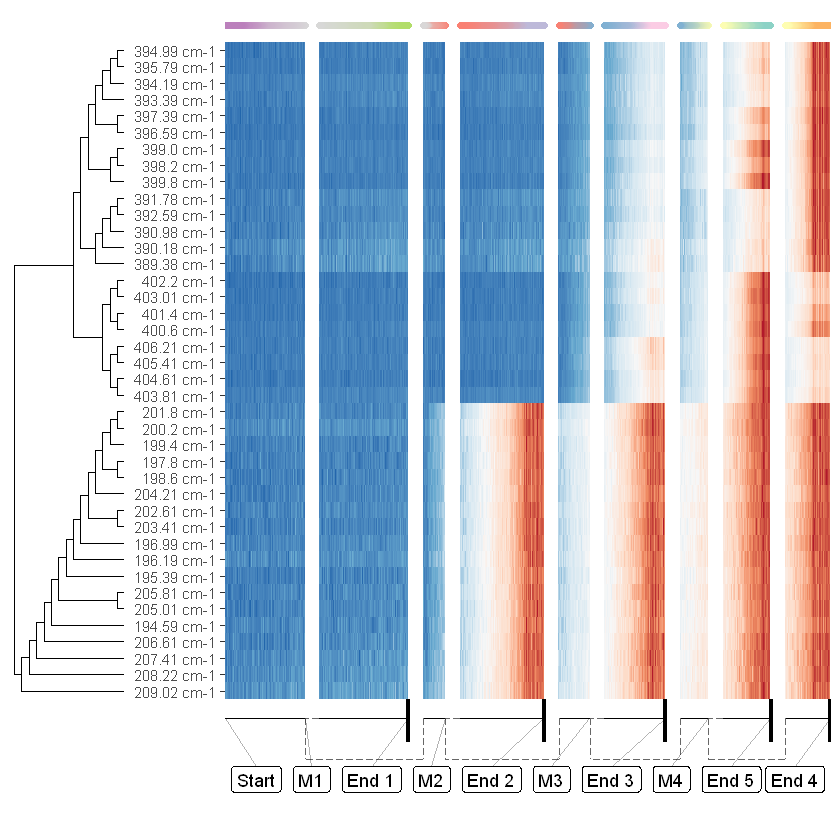

In [31]:
overall_feature_importances <- dynfeature::calculate_overall_feature_importance(simplified)
features <- overall_feature_importances %>% 
  top_n(40, importance) %>% 
  pull(feature_id)

heatmap <- plot_heatmap(simplified,
             expression_source = dataset$expression,                      
             features_oi = features,
             clust = "ward.D2",    
             margin = 0.03,
             scale = dynutils::scale_minmax
             )

#ggsave(file="heatmap_20.tiff", plot=heatmap, width=12, height=12, bg = "transparent")
#ggsave(file="heatmap_20.svg", plot=heatmap, width=12, height=12, bg = "transparent")
heatmap